# Cupy + mpi4py container benchmark
The container herein 

In [323]:
from pathlib import Path
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme()

In [324]:
# Test setup specification
osu_results_folder = Path("./results/")
tests = {
    "allgather": {"processes": 3, "metric": "Latency (us)", "name": "OMB Python MPI Allgather Test"},
    "bw": {"processes": 2, "metric": "Bandwidth (MB/s)", "name": "OMB-Py MPI Bandwidth Test"},
    "latency": {"processes": 2, "metric": "Latency (us)", "name": "OMB Python MPI Latency Test"},
}
raw_containers = [
    "cupy_mpi4py_libfabric2000.sif",
    "cupy_mpi4py_libfabric1220.sif",
    "mpi4py_libfabric1220_extmpich.sif",
    "mpi4py_libfabric2000_extmpich.sif",
    "mpi4py_libfabric1220_pip.sif",
    "mpi4py_libfabric2000_pip.sif",
    "mpi4py_libfabric1220_conda.sif",
    "mpi4py_libfabric2000_conda.sif",
]

# Prettify container names into parameter strings "mpi4py_libfabric1220_pip.sif" -> "mpi4py libfabric1220 pip"
containers = [c.split('.')[0].replace('_', ' ') for c in raw_containers]

In [325]:
# Helper functions
def extract_params_from_file(*, fd: Path, delimiter: str = '-') -> str:
    """
    Parses and extracts parameters from the file name
    
    Args:
        fd (Path): delimiter-separated string ending in .txt
        delimiter (str): default is hyphen '-'

    Returns:
        param_dict (dict): Extracted parameter dictionary
    """
    file_name = fd.name.split('.txt')[0]
    params = file_name.split(delimiter)
    param_dict = {"Slurmid": params[0],
                  "Benchmark": params[1],
                  "Nodes": params[2],
                  "Container": params[3].split('.')[0].replace('_', ' '),
                  "Buffer": params[4]}
    try:
        param_dict['HMEM'] = params[5]
    except:
        param_dict['HMEM'] = 'nohmem'
    return param_dict

In [326]:
def filter_df(df, **kwargs):
    """
    
    """
    for name, value in kwargs.items():
        if name == "Container":
            # string-compare all values to find substring in prettified container names
            # e.g. "libfabric2000" in "mpi4py libfabric2000 conda"
            df = df[[value in str(v) for v in df.values]]
        else:
            df = df[df[name] == value]

    return df

In [327]:
def read_osu_results_file(*, file_path: Path) -> pd.DataFrame:
    """
    Load the actual test/benchmark results from results file.

    Returns
    -------
    df_osu_results : pd.DataFrame
        A long-form pandas dataframe containing the results.

    Notes
    -----
    Assumes that the results file is similar to:

    # OMB Python MPI Allgather Test
    # Size (B)      Latency (us)
    1                       6.81
    2                       6.79
    4                       6.82
    ...

    I.e., it is a fixed with text file, with:
    - two header rows prefixed by "# ": 1. The name of the test, 2. The column names and units
    - a 16 character first column containing integers
    - a 12 character second column containing decimal numbers
    """
    with file_path.open(mode="r") as f:
        test_name = f.readline().removeprefix("# ").strip()
        column = f.readline().removeprefix("# ").strip()
        column_names = re.split(r"\s{2,}", column)
    osu_colspecs = [(0, 16), (16, 29)]
    osu_dtypes = {column_names[0]: "int64", column_names[1]: "float64"}
    df_osu_results = pd.read_fwf(
        file_path,
        colspecs=osu_colspecs,
        header=1,
        names=column_names,
        dtype=osu_dtypes,
    )
    params = extract_params_from_file(fd=file_path)
    df_osu_results["Benchmark"] = params['Benchmark']
    df_osu_results["Nodes"] = params['Nodes']
    df_osu_results["Container"] = params['Container']
    df_osu_results["Buffer"] = params['Buffer']
    df_osu_results["HMEM"] = params['HMEM']

    return df_osu_results

In [419]:
def show_osu_pivot_table(
    *, df: pd.DataFrame, metric: str, containers: list[str]
) -> pd.DataFrame:
    """
    Create a pivot table for the OSU results dataframe.

    Parameters
    ----------
    df : pd.DataFrame
        The OSU results dataframe to create a pivot table for.
    metric : str
        The metric used in the OSU benchmark.
    containers : list of str
        The containers in the OSU results dataframe.

    Returns
    -------
    df_pivot: pd.DataFrame
        The pivot table.
    """

    df_pivot = (
        df.pivot(index="Size (B)", columns=["Container", "Nodes", "Buffer", "HMEM"], values=[metric])
        .reindex(columns=containers, level="Container")
        .reindex(columns=["single", "multi"], level="Nodes")
        .reindex(columns=["numpy", "cupy"], level="Buffer")
    )
    return df_pivot

In [420]:
def barplot_osu_results(
    *, df: pd.DataFrame, benchmark: str, nodes: str,
) -> mpl.figure.Figure:
    """
    Create a barplot of OSU results dataframe.

    Create a plot of `metric` vs message size with `containers` overlaid and
    single/multi node facetted.

    Parameters
    ----------
    df : pd.DataFrame
        The OSU results dataframe to create a barplot for.
    benchmark : str
        A string signifying either single-node run or multi-node run, "single" or "multi"

    Returns
    -------
    mpl.figure.Figure
        The barplot figure handle.
    """
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))

    palette_colors = sns.color_palette('tab10')
    palette_dict = {container: color for container, color in zip(containers, palette_colors)}
    sns.barplot(
        df,
        x="Size (B)",
        y=tests[benchmark]["metric"],
        hue="Container",
        palette=palette_dict,
        legend="brief",
        ax=ax,
    )
    ax.tick_params(axis="x", labelrotation=45)
    ax.set_yscale("log")
    ax.legend(title="Multiple nodes" if nodes == "multi" else "Single node")

    fig.suptitle(f"LUMI-C OSU {tests[benchmark]["name"]} results - {tests[benchmark]["processes"]} processes")
    fig.tight_layout()

    return fig

In [421]:
# Load the data into a DataFrame with all results concatenated
osu_df = pd.concat(
    [
        read_osu_results_file(file_path=file_path)
        for file_path in osu_results_folder.glob("*.txt")
    ]
)
osu_df= osu_df.sort_values(by=['Container'])

# CPU Bandwidth

In [422]:
benchmark = "bw"
print(f"LUMI-C OSU {tests[benchmark]['name']} results - {tests[benchmark]['processes']} processes")
print("(higher is better)")
show_osu_pivot_table(
    df=filter_df(osu_df, Benchmark=benchmark, Buffer="numpy"),
    metric=tests[benchmark]["metric"],
    containers=containers,
)

LUMI-C OSU OMB-Py MPI Bandwidth Test results - 2 processes
(higher is better)


Bandwidth (MB/s)                                      \
Container cupy mpi4py libfabric2000           cupy mpi4py libfabric1220   
Nodes                        single     multi                    single   
Buffer                        numpy     numpy                     numpy   
HMEM                           hmem      hmem                      hmem   
Size (B)                                                                  
1                              0.70      0.72                      0.70   
2                              1.41      1.48                      1.43   
4                              2.83      3.10                      2.87   
8                              5.71      6.19                      5.74   
16                            11.49     12.39                     11.49   
32                            23.22     24.64                     23.00   
64                            46.56     48.90                     45.90   
128                           92.24     97.59                     91.41   
256                          183.88    196.55                    182.21   
512                          365.83    393.49                    360.56   
1024                         726.01    786.71                    711.62   
2048                        1413.10   1572.62                   1384.57   
4096                        2732.12   3144.94                   2647.51   
8192                        4182.61   6054.39                   4014.99   
16384                       4587.35   7596.58                   4604.89   
32768                       6183.09  15555.04                   6102.43   
65536                       7572.52  20242.53                   7365.03   
131072                      8357.65  21713.69                   8227.34   
262144                      8993.42  22246.20                   8666.75   
524288                      8895.44  22553.35                   8856.74   
1048576                     8985.16  20782.41                   9061.33   
2097152                     9367.54  19674.31                   9179.51   
4194304                     9509.85  20101.44                   9286.42   

                                                             \
Container           mpi4py libfabric1220 extmpich             
Nodes         multi                        single     multi   
Buffer        numpy                         numpy     numpy   
HMEM           hmem                        nohmem    nohmem   
Size (B)                                                      
1              0.80                          0.76      0.90   
2              1.59                          1.52      1.78   
4              3.21                          3.07      3.58   
8              6.41                          6.14      7.14   
16            12.82                         12.30     14.30   
32            25.63                         24.60     28.62   
64            50.96                         49.09     57.27   
128          102.13                         99.29    114.36   
256          197.45                        197.88    223.88   
512          394.52                        392.75    446.37   
1024         789.80                        772.22    894.29   
2048        1580.11                       1509.29   1789.09   
4096        3173.29                       2889.98   3578.33   
8192        6069.36                       5360.86   6856.52   
16384       8704.66                       5746.76   7435.48   
32768      16640.99                       8658.92  16801.52   
65536      20620.64                      11723.97  20392.93   
131072     22421.58                      14134.26  22410.08   
262144     23022.91                      10588.16  22810.01   
524288     23151.24                       9249.54  23021.22   
1048576    22944.00                       9602.83  22722.03   
2097152    22720.34                       9621.88  22593.69   
4194304    22724.18                       9683.38  22424.03   

               

The external MPICH has significantly better multi-node performance and slightly worse single-node performance, as illustrated in the following two plots:

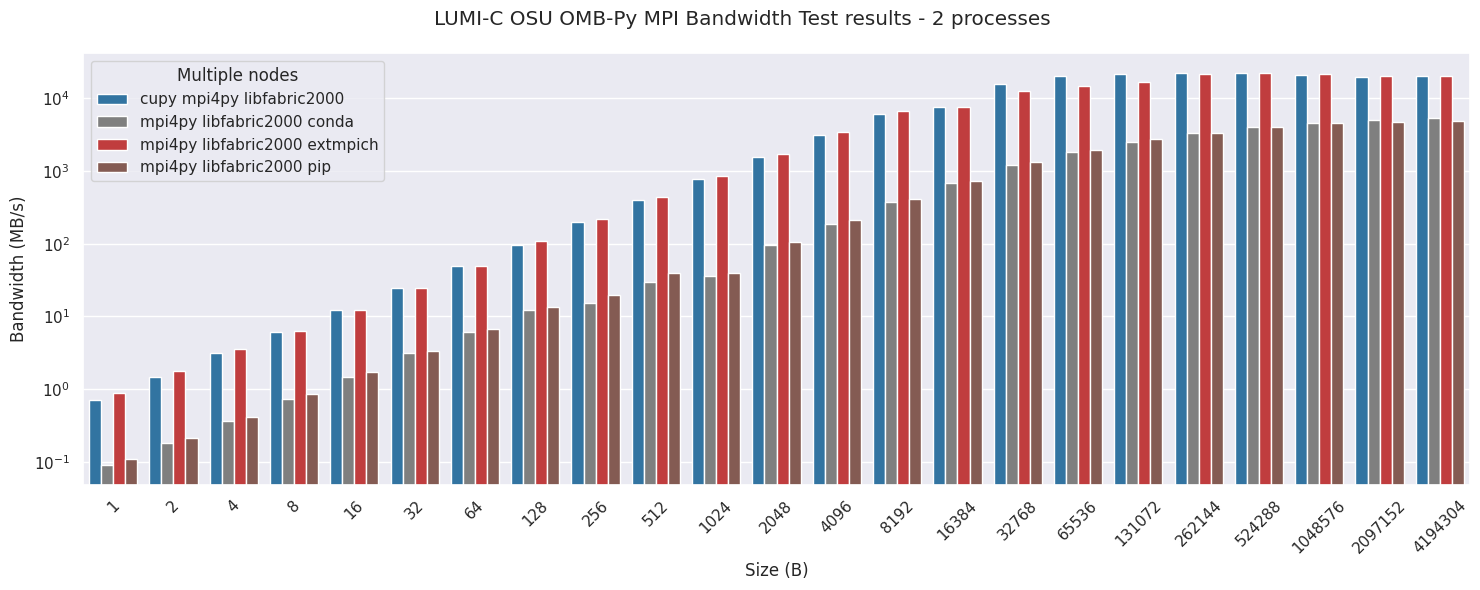

In [423]:
benchmark = "bw"; nodes='multi'
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, Container="libfabric2000", Nodes=nodes, Buffer="numpy"),
    benchmark=benchmark, nodes=nodes
)

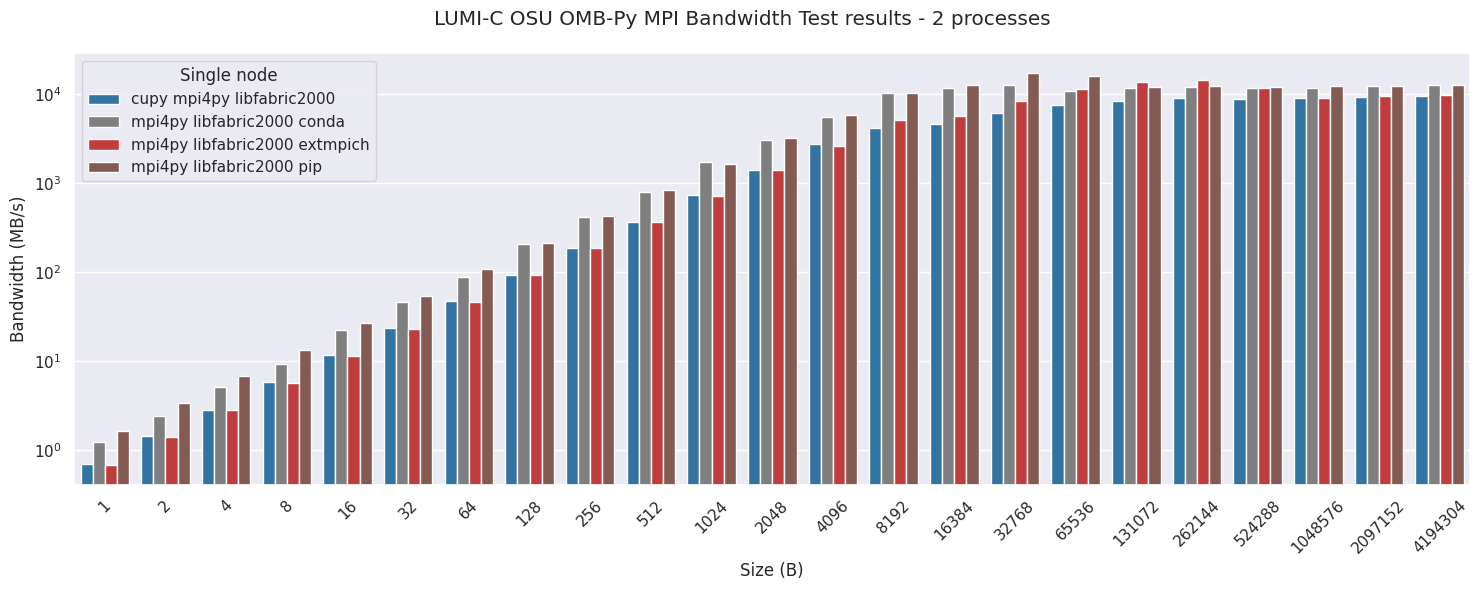

In [424]:
benchmark = "bw"; nodes='single'
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, Container="libfabric2000", Nodes=nodes, Buffer="numpy"),
    benchmark=benchmark, nodes=nodes
)

There are very little performance difference between different libfabric versions as illustrated here

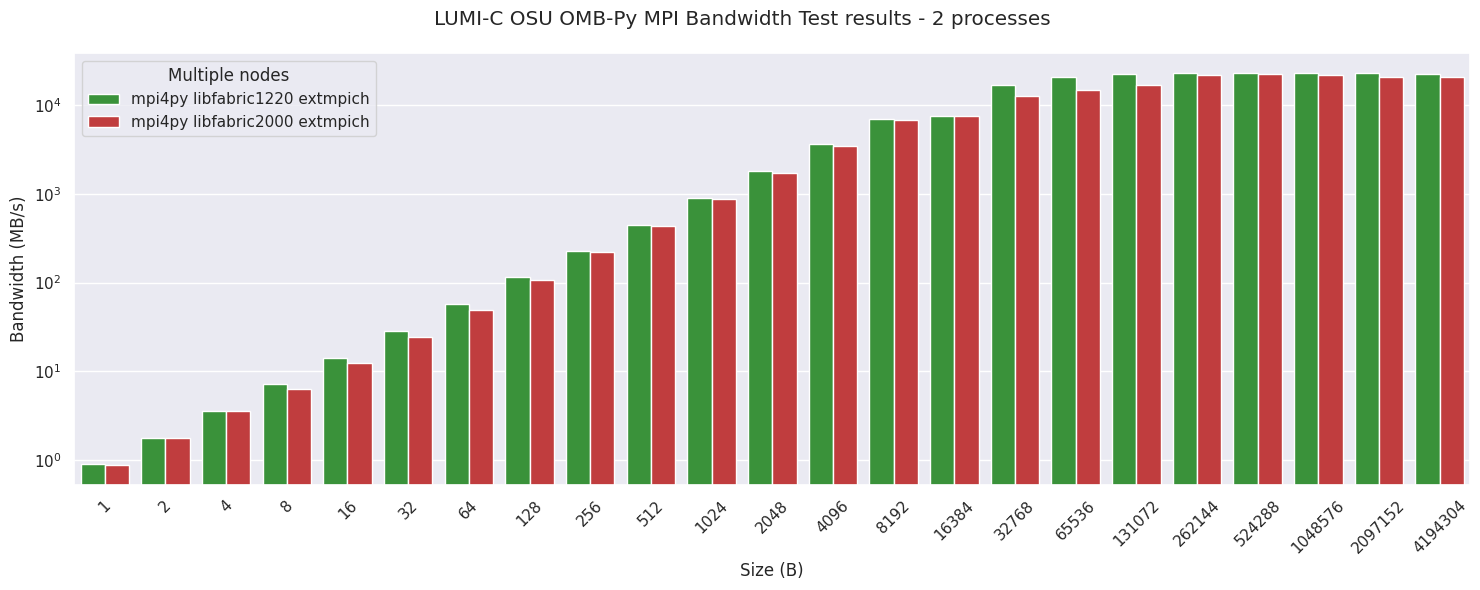

In [425]:
benchmark = "bw"; nodes='multi'
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, Container="extmpich", Nodes=nodes, Buffer="numpy"),
    benchmark=benchmark, nodes=nodes
)

# GPU Bandwidth

In [426]:
benchmark = "bw"
print(f"LUMI-C OSU {tests[benchmark]['name']} results - {tests[benchmark]['processes']} processes")
print("(higher is better)")
show_osu_pivot_table(
    df=filter_df(osu_df, Benchmark=benchmark, Container="cupy"),
    metric=tests[benchmark]["metric"],
    containers=containers,
)

LUMI-C OSU OMB-Py MPI Bandwidth Test results - 2 processes
(higher is better)


Bandwidth (MB/s)                                 \
Container cupy mpi4py libfabric2000                                  
Nodes                        single                multi             
Buffer                        numpy       cupy     numpy      cupy   
HMEM                           hmem       hmem      hmem      hmem   
Size (B)                                                             
1                              0.70       0.05      0.72      0.04   
2                              1.41       0.11      1.48      0.08   
4                              2.83       0.22      3.10      0.16   
8                              5.71       0.43      6.19      0.32   
16                            11.49       0.87     12.39      0.65   
32                            23.22       1.73     24.64      1.30   
64                            46.56       3.47     48.90      2.60   
128                           92.24       6.91     97.59      5.19   
256                          183.88      13.80    196.55     83.56   
512                          365.83      27.48    393.49    167.07   
1024                         726.01      54.81    786.71    334.91   
2048                        1413.10     108.85   1572.62    673.77   
4096                        2732.12     216.64   3144.94   1351.94   
8192                        4182.61     426.18   6054.39   2660.42   
16384                       4587.35     849.21   7596.58   5304.53   
32768                       6183.09    1794.01  15555.04  10597.93   
65536                       7572.52    3474.98  20242.53  19313.17   
131072                      8357.65    6681.46  21713.69  21408.25   
262144                      8993.42   11801.16  22246.20  22643.60   
524288                      8895.44   19138.53  22553.35  23320.47   
1048576                     8985.16   36744.81  20782.41  23640.86   
2097152                     9367.54   68626.15  19674.31  23806.46   
4194304                     9509.85  126232.24  20101.44  23888.10   

                                                                    
Container cupy mpi4py libfabric1220                                 
Nodes                        single                multi            
Buffer                        numpy       cupy     numpy      cupy  
HMEM                           hmem       hmem      hmem      hmem  
Size (B)                                                            
1                              0.70       0.06      0.80      0.04  
2                              1.43       0.12      1.59      0.08  
4                              2.87       0.23      3.21      0.16  
8                              5.74       0.47      6.41      0.32  
16                            11.49       0.93     12.82      0.64  
32                            23.00       1.87     25.63      1.28  
64                            45.90       3.74     50.96      2.55  
128                           91.41       7.42    102.13      5.08  
256                          182.21      14.83    197.45     84.98  
512                          360.56      29.64    394.52    170.02  
1024                         711.62      58.85    789.80    338.50  
2048                        1384.57     117.75   1580.11    687.55  
4096                        2647.51     233.30   3173.29   1375.60  
8192                        4014.99     461.91   6069.36   2690.47  
16384                       4604.89     911.61   8704.66   5357.92  
32768                       6102.43    1927.69  16640.99  10622.51  
65536                       7365.03    3737.65  20620.64  19365.79  
131072                      8227.34    7223.52  22421.58  21405.60  
262144                      8666.75   12627.97  23022.91  22646.57  
524288                      8856.74   20104.70  23151.24  23316.95  
1048576                     9061.33   40421.03  22944.00  23639.45  
2097152                     9179.51   74467.20  22720.34  23804.76  
4194304                     9286.42  139994.73  22724.18

NOTE: The single node cupy data transfer does not actually transfer any data! The exponential doubling of the Bandwidth is a result of the message sizes doubling while the transfer time stays the same.

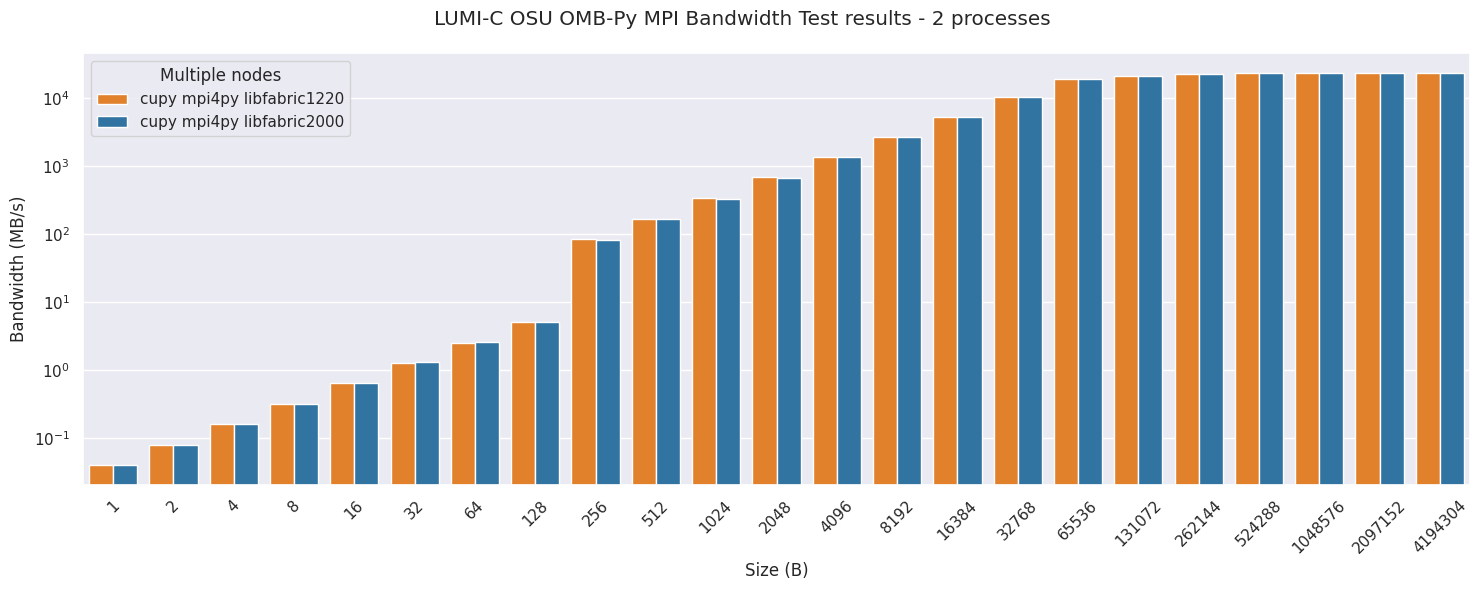

In [429]:
benchmark = "bw"
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, Buffer="cupy", Nodes="multi"),
    benchmark=benchmark, nodes='multi'
)

Notably, at small byte-transfer sizes <= 128 the performance drop-off for GPU buffers, however the peak performance at large byte-transfer sizes is better for GPU buffers than CPU buffers.

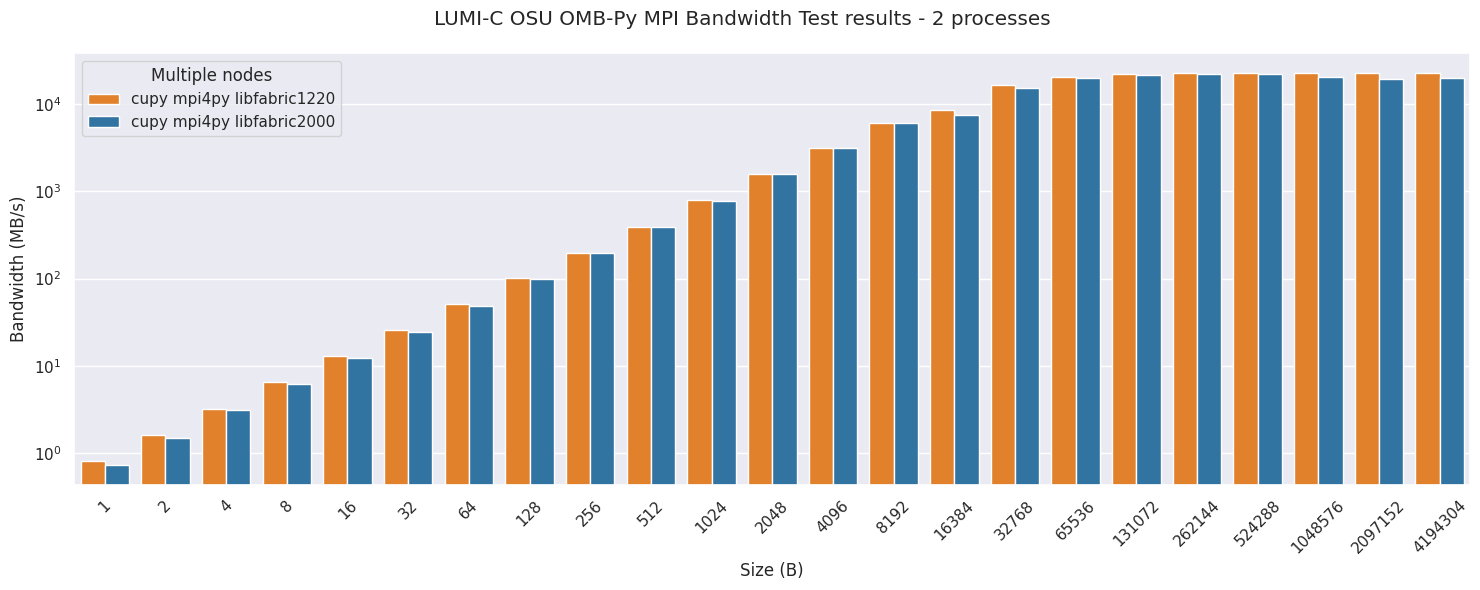

In [432]:
benchmark = "bw"
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, Buffer='numpy', Container="cupy", Nodes="multi"),
    benchmark=benchmark, nodes='multi'
)

## Latency test results

In [380]:
benchmark = "latency"
print(f"LUMI-C OSU {tests[benchmark]['name']} results - {tests[benchmark]['processes']} processes")
print("(lower is better)")
show_osu_pivot_table(
    df=filter_df(osu_df, Benchmark=benchmark, Container="libfabric2000",  Buffer="numpy"),
    metric=tests[benchmark]["metric"],
    containers=containers,
)

LUMI-C OSU OMB Python MPI Latency Test results - 2 processes
(lower is better)


Latency (us)                                        \
Container cupy mpi4py libfabric2000         mpi4py libfabric2000 extmpich   
Nodes                        single   multi                        single   
Buffer                        numpy   numpy                         numpy   
HMEM                           hmem    hmem                        nohmem   
Size (B)                                                                    
0                              1.33    2.92                          1.23   
1                              1.98    3.07                          1.89   
2                              1.97    3.07                          1.85   
4                              1.98    3.07                          1.83   
8                              1.97    3.07                          1.93   
16                             1.97    3.07                          1.89   
32                             1.96    3.07                          1.85   
64                             1.97    3.07                          1.83   
128                            1.97    3.60                          1.84   
256                            1.98    3.72                          1.85   
512                            2.01    3.75                          1.87   
1024                           2.05    3.84                          1.91   
2048                           2.11    3.97                          1.96   
4096                           2.22    4.16                          2.11   
8192                           2.45    7.21                          2.29   
16384                          4.21    8.46                          4.16   
32768                          5.42   10.37                          5.47   
65536                          7.47   13.10                          7.47   
131072                        13.01   17.86                         12.49   
262144                        25.68   26.94                         25.31   
524288                        48.16   40.73                         47.22   
1048576                       89.75   64.82                         91.56   
2097152                      154.80  106.64                        179.96   
4194304                      296.20  192.28                        316.17   

                                                     \
Container         mpi4py libfabric2000 pip            
Nodes       multi                   single    multi   
Buffer      numpy                    numpy    numpy   
HMEM       nohmem                   nohmem   nohmem   
Size (B)                                              
0            2.80                     0.76    17.41   
1            2.95                     0.79    17.41   
2            2.94                     0.77    17.37   
4            2.94                     0.77    17.37   
8            2.95                     0.76    17.37   
16           2.94                     0.77    17.38   
32           2.94                     0.76    17.41   
64           2.95                     0.77    17.58   
128          3.48                     0.77    17.48   
256          3.59                     0.78    20.34   
512          3.62                     0.83    23.57   
1024         3.69                     0.85    27.82   
2048         3.90                     0.90    25.24   
4096         4.03                     1.03    26.20   
8192         7.07                     1.22    28.36   
16384        8.24                     2.33    32.04   
32768       10.42                     2.91    42.24   
65536       13.72                     4.08    55.79   
131072      18.33                     7.65    76.46   
262144      25.72                    17.70   116.22   
524288      39.45                    34.56   180.13   
1048576     62.92                    65.63   304.18   
2097152    105.44                    95.11   538.01   
4194304    188.18                   178.89  1000.17   

                                              
Container mpi4

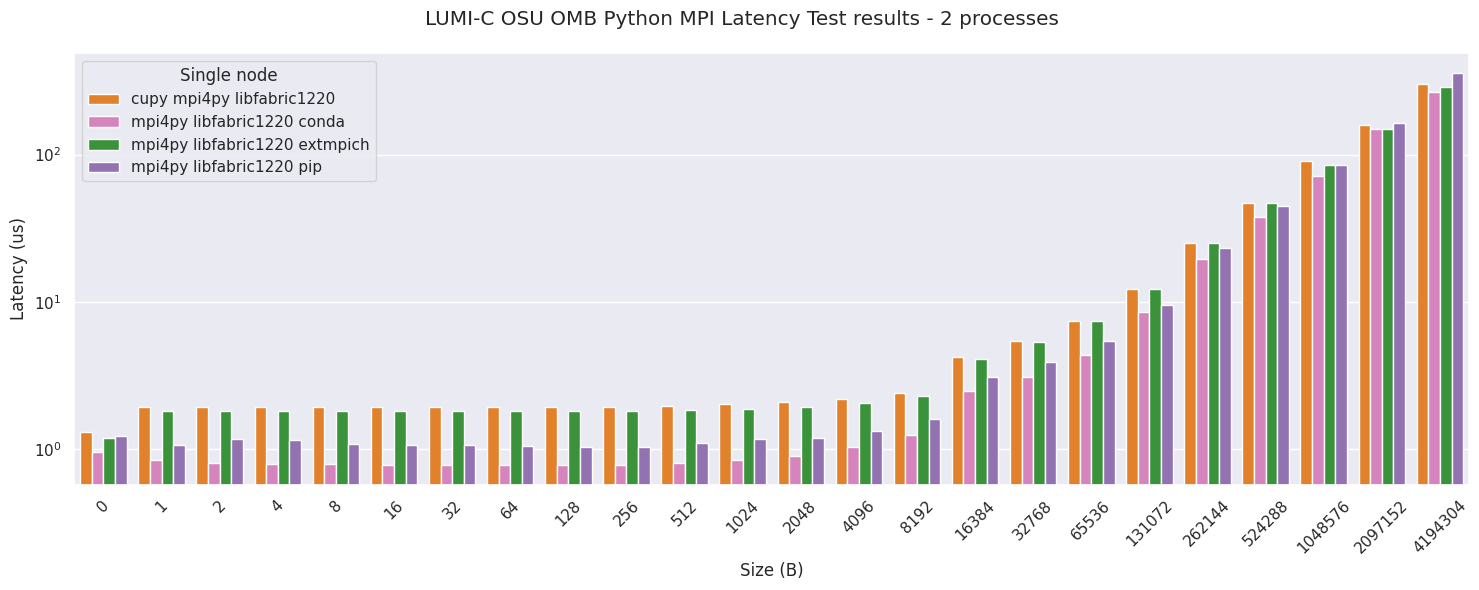

In [381]:
benchmark = "latency"
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, Container="libfabric1220", Nodes='single', Buffer="numpy"),
    benchmark=benchmark, nodes='single'
)

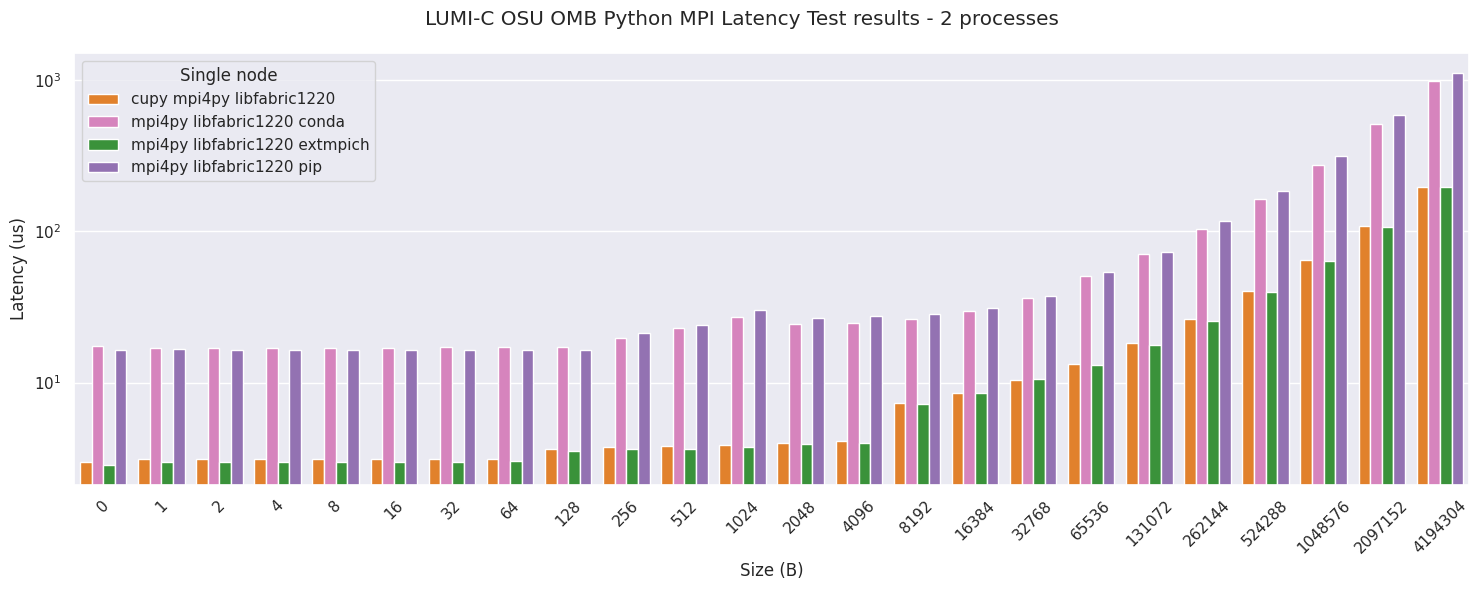

In [382]:
benchmark = "latency"
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, Container="libfabric1220", Nodes='multi', Buffer="numpy"),
    benchmark=benchmark, nodes='single'
)